In [19]:
from tcn import TCN
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from tensorflow.keras import Sequential
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from joblib import dump
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K

In [20]:
X_train = pd.read_csv("../../../Split Data/Training Dataset/X_train #1.csv").drop(columns=["Unnamed: 0"])
y_train = pd.read_csv("../../../Split Data/Training Dataset/y_train #1.csv", index_col=0)
X_val = pd.read_csv("../../../Split Data/Validation Dataset/X_val #1.csv").drop(columns=["Unnamed: 0"])
y_val = pd.read_csv("../../../Split Data/Validation Dataset/y_val #1.csv", index_col=0)
X_test = pd.read_csv("../../../Split Data/Testing Dataset/X_test #1.csv").drop(columns=["Unnamed: 0"])
y_test = pd.read_csv("../../../Split Data/Testing Dataset/y_test #1.csv", index_col=0)

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  
X_val_scaled = scaler.transform(X_val)   
X_test_scaled = scaler.transform(X_test) 

In [22]:
X_train = np.array(X_train_scaled).reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)  
X_val = np.array(X_val_scaled).reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)  
X_test = np.array(X_test_scaled).reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)  

In [23]:
num_classes = 2   
kernel_size = 5
dilations = [4, 8, 16, 32, 64] 
max_len = X_train.shape[1] 
dropout_rate = 0.05

In [24]:
inputs = Input(shape=(max_len, 1))

In [25]:
tcn = TCN(
    nb_filters= 128,
    nb_stacks = 2,
    kernel_size=kernel_size,
    dilations=dilations,
    dropout_rate=dropout_rate,
    use_layer_norm=True,
    return_sequences = True
)(inputs)

In [26]:
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

In [27]:
max_pooling = GlobalMaxPooling1D()(tcn)

In [28]:
avg_pooling = GlobalAveragePooling1D()(tcn)

In [29]:
pooling = Concatenate()([max_pooling, avg_pooling])

In [30]:
dense1 = Dense(64, activation= 'relu')(pooling)

In [31]:
dropout1 = Dropout(0.2)(dense1)

In [32]:
outputs = Dense(2, activation='softmax')(dropout1)

In [33]:
def f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    p = true_positives / (predicted_positives + K.epsilon())
    r = true_positives / (possible_positives + K.epsilon())
    return 2 * ((p * r) / (p + r + K.epsilon()))

In [34]:
model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate = 0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', f1]
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 11, 1)]              0         []                            
                                                                                                  
 tcn_1 (TCN)                 (None, 11, 128)              1565056   ['input_2[0][0]']             
                                                                                                  
 global_max_pooling1d_1 (Gl  (None, 128)                  0         ['tcn_1[0][0]']               
 obalMaxPooling1D)                                                                                
                                                                                                  
 global_average_pooling1d_1  (None, 128)                  0         ['tcn_1[0][0]']         

In [35]:
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)

y_train shape: (315123, 2)
y_val shape: (67526, 2)


In [36]:
history = model.fit(X_train, y_train, epochs=100,
          validation_data=(X_val, y_val), verbose = 1, 
          callbacks = 
          [ModelCheckpoint(filepath="TCN #1.h5", 
          monitor='val_f1', mode='max',save_best_only=True), 
          EarlyStopping(monitor='val_f1', patience =5, 
          restore_best_weights= True, mode ="max")], 
          batch_size = 128)

Epoch 1/100


2462/2462 [==============================] - ETA: 0s - loss: 0.3796 - accuracy: 0.8501 - f1: 0.8501

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2462/2462 [==============================] - 144s 53ms/step - loss: 0.3796 - accuracy: 0.8501 - f1: 0.8501 - val_loss: 0.3362 - val_accuracy: 0.8606 - val_f1: 0.8606
Epoch 2/100
2462/2462 [==============================] - 128s 52ms/step - loss: 0.3431 - accuracy: 0.8619 - f1: 0.8619 - val_loss: 0.3319 - val_accuracy: 0.8638 - val_f1: 0.8638
Epoch 3/100
2462/2462 [==============================] - 126s 51ms/step - loss: 0.3389 - accuracy: 0.8630 - f1: 0.8630 - val_loss: 0.3292 - val_accuracy: 0.8651 - val_f1: 0.8651
Epoch 4/100
2462/2462 [==============================] - 127s 52ms/step - loss: 0.3365 - accuracy: 0.8635 - f1: 0.8635 - val_loss: 0.3261 - val_accuracy: 0.8676 - val_f1: 0.8676
Epoch 5/100
2462/2462 [==============================] - 126s 51ms/step - loss: 0.3351 - accuracy: 0.8636 - f1: 0.8636 - val_loss: 0.3254 - val_accuracy: 0.8681 - val_f1: 0.8681
Epoch 6/100
2462/2462 [==============================] - 126s 51ms/step - loss: 0.3335 - accuracy: 0.8641 - f1: 0.8641 - v

In [37]:
TCN_model = load_model('TCN #1.h5', custom_objects={'f1': f1})

In [38]:
y_test = to_categorical(y_test, 2)

In [39]:
results = TCN_model.evaluate(X_test, y_test, verbose = 1)

2111/2111 [==============================] - 30s 13ms/step - loss: 0.3232 - accuracy: 0.8691 - f1: 0.8691


In [40]:
y_pred = TCN_model.predict(X_test)

2111/2111 [==============================] - 27s 12ms/step


In [41]:
y_test = y_test.argmax(axis=1)
y_pred = y_pred.argmax(axis=1)

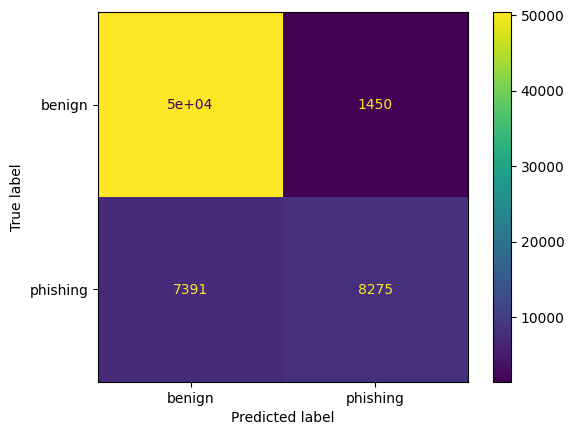

In [42]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
matrix = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["benign", "phishing"])                            
matrix.plot()

In [43]:
Accuracy = metrics.accuracy_score(y_test, y_pred)
Precision = metrics.precision_score(y_test, y_pred)
Recall = metrics.recall_score(y_test, y_pred)
F1_score = metrics.f1_score(y_test, y_pred)

In [44]:
print({"Accuracy":Accuracy,"Precision":Precision,"Recall":Recall,"F1_score":F1_score})

{'Accuracy': 0.8690745923852681, 'Precision': 0.8508997429305912, 'Recall': 0.5282139665517681, 'F1_score': 0.6518057579457288}


In [45]:
df = pd.read_csv("../Metrics of Dataset #1.csv")

In [46]:
metrics = pd.DataFrame({"Model": "TCN", "Accuracy": [Accuracy], "Precision":[Precision], "Recall": [Recall], "F1_score": [F1_score]})

In [47]:
df = pd.concat([df, metrics], ignore_index=True)

In [48]:
df.head()

,Model,Accuracy,Precision,Recall,F1_score
0,LinearSVC,0.796748,0.840168,0.153007,0.258869
1,Random Forest,0.870289,0.872345,0.516469,0.648811
2,XGBoost,0.866320,0.876318,0.493425,0.631355
3,MLP,0.869001,0.875799,0.507277,0.642441
4,TCN,0.869075,0.850900,0.528214,0.651806


In [49]:
df.to_csv("../Metrics of Dataset #1.csv", index=False)